# Import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings(action='ignore')

## Dataset

In [2]:
path= '/opt/ml/level1_bookratingprediction_recsys-level1-recsys-06/data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)



users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


In [3]:
seed = 42

## Users EDA & Preprocessing

In [4]:
users

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0
...,...,...,...
68087,278376,"danville, pennsylvania, usa",54.0
68088,278621,"victoria, delaware, canada",74.0
68089,278636,"irvington, alabama, usa",NaN
68090,278659,"vancouver, washington, usa",33.0


In [5]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [7]:
users.describe()

,user_id,age
count,68092.000000,40259.000000
mean,139381.329539,36.069873
std,80523.969862,13.842571
min,8.000000,5.000000
25%,69008.750000,25.000000
50%,138845.500000,34.000000
75%,209388.250000,45.000000
max,278854.000000,99.000000


### 1. 결측치 확인

1. 전체 비율

In [8]:
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

2. 개수 (내림차순)

In [9]:
users.isna().sum().sort_values(ascending = False)

age         27833
user_id         0
location        0
dtype: int64

###### users dataset에 age에만 27833개

### 2. 전처리

In [10]:
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
users = users.drop(['location'], axis=1)

In [11]:
print(users.shape)
users

(68092, 5)


,user_id,age,location_city,location_state,location_country
0,8,NaN,timmins,ontario,canada
1,11400,49.0,ottawa,ontario,canada
2,11676,NaN,n/a,n/a,n/a
3,67544,30.0,toronto,ontario,canada
4,85526,36.0,victoria,british columbia,canada
...,...,...,...,...,...
68087,278376,54.0,danville,pennsylvania,usa
68088,278621,74.0,victoria,delaware,canada
68089,278636,NaN,irvington,alabama,usa
68090,278659,33.0,vancouver,washington,usa


## Books EDA & Preprocessing

### 1. 결측치 처리

In [12]:
books.isna().sum()/len(books)

isbn                   0.000000
book_title             0.000000
book_author            0.000000
year_of_publication    0.000000
publisher              0.000000
img_url                0.000000
language               0.449468
category               0.460326
summary                0.449468
img_path               0.000000
dtype: float64

In [13]:
books.isna().sum().sort_values(ascending = False)

category               68851
language               67227
summary                67227
isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
img_path                   0
dtype: int64

In [54]:
books['category'].value_counts()[:20]

['Fiction']                      32956
['Juvenile Fiction']              5804
['Biography & Autobiography']     3320
['History']                       1925
['Religion']                      1818
['Juvenile Nonfiction']           1417
['Social Science']                1231
['Humor']                         1161
['Body, Mind & Spirit']           1109
['Business & Economics']          1070
['Cooking']                       1025
['Health & Fitness']               968
['Family & Relationships']         959
['Computers']                      730
['Travel']                         651
['Self-Help']                      640
['Psychology']                     635
['Poetry']                         626
['Science']                        624
['Art']                            562
Name: category, dtype: int64

## Ratings EDA & Preprocessing

In [14]:
train_ratings

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9
...,...,...,...
306790,278843,0743525493,7
306791,278851,067161746X,6
306792,278851,0884159221,7
306793,278851,0912333022,7


### ratings df 
* ratings -> train과 test ratings의 concat 
* train_ratings -> train_ratings와 user, books merge
* test_ratings -> test_ratings와 user, books merge

In [15]:
ratings = pd.concat([train_ratings, test_ratings]).reset_index(drop=True)

In [16]:
context_df = ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
context_df

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
0,8,0002005018,4,NaN,timmins,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
1,67544,0002005018,7,30.0,toronto,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
2,123629,0002005018,8,NaN,kingston,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
3,200273,0002005018,8,NaN,comber,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
4,210926,0002005018,9,NaN,guelph,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
...,...,...,...,...,...,...,...,...,...,...,...
383489,278543,1576734218,0,39.0,valenica,california,usa,['Family & Relationships'],Multnomah,en,Gary Ezzo
383490,278563,3492223710,0,37.0,wien,wien,austria,"['Mythology, Classical']",Piper,de,Michael KÃ¶hlmeier
383491,278633,1896095186,0,NaN,sandy,utah,usa,['Fiction'],Polestar Book Publishers,en,Anne Fleming
383492,278668,8408044079,0,48.0,madrid,madrid,spain,NaN,Planeta Publishing Corporation,NaN,Gonzalo Torrrente Ballester


In [17]:
train_df = train_ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
test_df = test_ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')

In [18]:
train_df

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
0,8,0002005018,4,NaN,timmins,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
1,67544,0002005018,7,30.0,toronto,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
2,123629,0002005018,8,NaN,kingston,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
3,200273,0002005018,8,NaN,comber,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
4,210926,0002005018,9,NaN,guelph,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,28.0,pismo beach,california,usa,NaN,Simon & Schuster Audio,NaN,David Gardner
306791,278851,067161746X,6,33.0,dallas,texas,usa,['Humor'],Pocket Books,en,P.J. O'Rourke
306792,278851,0884159221,7,33.0,dallas,texas,usa,NaN,Lone Star Books,NaN,Claude Dooley
306793,278851,0912333022,7,33.0,dallas,texas,usa,['Fiction'],Kqed Books,en,Jeremy Lloyd


In [19]:
train_df.info

<bound method DataFrame.info of         user_id        isbn  rating   age location_city location_state  \
0             8  0002005018       4   NaN       timmins        ontario   
1         67544  0002005018       7  30.0       toronto        ontario   
2        123629  0002005018       8   NaN      kingston        ontario   
3        200273  0002005018       8   NaN        comber        ontario   
4        210926  0002005018       9   NaN        guelph        ontario   
...         ...         ...     ...   ...           ...            ...   
306790   278843  0743525493       7  28.0   pismo beach     california   
306791   278851  067161746X       6  33.0        dallas          texas   
306792   278851  0884159221       7  33.0        dallas          texas   
306793   278851  0912333022       7  33.0        dallas          texas   
306794   278851  1569661057      10  33.0        dallas          texas   

       location_country       category                 publisher language  \
0 

### Users train + test dataset 
1. city (도시)
2. state (주)
3. country (나라)

In [20]:
loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

In [21]:
train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
train_df['location_country'] = train_df['location_country'].map(loc_country2idx)

test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
test_df['location_country'] = test_df['location_country'].map(loc_country2idx)


In [22]:
train_df

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
0,8,0002005018,4,NaN,0,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
1,67544,0002005018,7,30.0,1,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
2,123629,0002005018,8,NaN,2,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
3,200273,0002005018,8,NaN,3,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
4,210926,0002005018,9,NaN,4,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,28.0,1607,5,1,NaN,Simon & Schuster Audio,NaN,David Gardner
306791,278851,067161746X,6,33.0,19,10,1,['Humor'],Pocket Books,en,P.J. O'Rourke
306792,278851,0884159221,7,33.0,19,10,1,NaN,Lone Star Books,NaN,Claude Dooley
306793,278851,0912333022,7,33.0,19,10,1,['Fiction'],Kqed Books,en,Jeremy Lloyd


In [23]:
train_df.isnull().sum()

user_id                  0
isbn                     0
rating                   0
age                  92662
location_city            0
location_state           0
location_country         0
category            121221
publisher                0
language            119084
book_author              0
dtype: int64

In [24]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

In [25]:
train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
train_df['age'] = train_df['age'].apply(age_map)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
test_df['age'] = test_df['age'].apply(age_map)

In [26]:
train_df

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
0,8,0002005018,4,3,0,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
1,67544,0002005018,7,3,1,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
2,123629,0002005018,8,3,2,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
3,200273,0002005018,8,3,3,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
4,210926,0002005018,9,3,4,0,0,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,2,1607,5,1,NaN,Simon & Schuster Audio,NaN,David Gardner
306791,278851,067161746X,6,3,19,10,1,['Humor'],Pocket Books,en,P.J. O'Rourke
306792,278851,0884159221,7,3,19,10,1,NaN,Lone Star Books,NaN,Claude Dooley
306793,278851,0912333022,7,3,19,10,1,['Fiction'],Kqed Books,en,Jeremy Lloyd


### Books train + test dataset 

In [27]:
category2idx = {v:k for k,v in enumerate(context_df['category'].unique())}
publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
language2idx = {v:k for k,v in enumerate(context_df['language'].unique())}
author2idx = {v:k for k,v in enumerate(context_df['book_author'].unique())}

In [28]:
train_df['category'] = train_df['category'].map(category2idx)
train_df['publisher'] = train_df['publisher'].map(publisher2idx)
train_df['language'] = train_df['language'].map(language2idx)
train_df['book_author'] = train_df['book_author'].map(author2idx)

test_df['category'] = test_df['category'].map(category2idx)
test_df['publisher'] = test_df['publisher'].map(publisher2idx)
test_df['language'] = test_df['language'].map(language2idx)
test_df['book_author'] = test_df['book_author'].map(author2idx)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 전처리 완료

In [29]:
# 컬럼 개수
print(len(train_df.columns))
train_df.columns

11


Index(['user_id', 'isbn', 'rating', 'age', 'location_city', 'location_state',
       'location_country', 'category', 'publisher', 'language', 'book_author'],
      dtype='object')

In [30]:
len(train_df['isbn'].unique())
for col in train_df.columns:
    print(len(train_df[col].unique()))

59803
129777
10
6
11374
1487
318
3873
10408
25
54716


In [31]:
# 결측치 확인
train_df.isnull().sum().sort_values()

user_id             0
isbn                0
rating              0
age                 0
location_city       0
location_state      0
location_country    0
category            0
publisher           0
language            0
book_author         0
dtype: int64

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 306794
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           306795 non-null  int64 
 1   isbn              306795 non-null  object
 2   rating            306795 non-null  int64 
 3   age               306795 non-null  int64 
 4   location_city     306795 non-null  int64 
 5   location_state    306795 non-null  int64 
 6   location_country  306795 non-null  int64 
 7   category          306795 non-null  int64 
 8   publisher         306795 non-null  int64 
 9   language          306795 non-null  int64 
 10  book_author       306795 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 28.1+ MB


In [33]:
train_df.reset_index(drop = True)

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
0,8,0002005018,4,3,0,0,0,0,0,0,0
1,67544,0002005018,7,3,1,0,0,0,0,0,0
2,123629,0002005018,8,3,2,0,0,0,0,0,0
3,200273,0002005018,8,3,3,0,0,0,0,0,0
4,210926,0002005018,9,3,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,2,1607,5,1,5,2171,1,1272
306791,278851,067161746X,6,3,19,10,1,7,222,0,69
306792,278851,0884159221,7,3,19,10,1,5,10406,1,54713
306793,278851,0912333022,7,3,19,10,1,3,6387,0,54714


In [34]:
train_df.isnull().sum()


user_id             0
isbn                0
rating              0
age                 0
location_city       0
location_state      0
location_country    0
category            0
publisher           0
language            0
book_author         0
dtype: int64

* isbn 혼자 Object Type -> 어짜피 mapping 하면서 idx로 바껴서 int type으로 변경됌

### 도시, 주, 나라, 카테고리, 출판사, 언어, 저자 중복 없앤 값들의 index와 개수

In [35]:
idx = {
        "loc_city2idx":loc_city2idx,
        "loc_state2idx":loc_state2idx,
        "loc_country2idx":loc_country2idx,
        "category2idx":category2idx,
        "publisher2idx":publisher2idx,
        "language2idx":language2idx,
        "author2idx":author2idx,
    }

In [36]:
print(f'도시의 unique 개수:  {len(loc_city2idx)}')
print(f'주의 unique 개수:  {len(loc_state2idx)}')
print(f'나라의 unique 개수:  {len(loc_country2idx)}')
print(f'카테고리의 unique 개수:  {len(category2idx)}')
print(f'출판사의 unique 개수:  {len(publisher2idx)}')
print(f'언어의 unique 개수:  {len(language2idx)}')
print(f'저자의 unique 개수:  {len(author2idx)}')


도시의 unique 개수:  12267
주의 unique 개수:  1609
나라의 unique 개수:  347
카테고리의 unique 개수:  4293
출판사의 unique 개수:  11571
언어의 unique 개수:  27
저자의 unique 개수:  62059


In [37]:
language2idx

{'en': 0,
 nan: 1,
 'de': 2,
 'fr': 3,
 'es': 4,
 'ca': 5,
 'it': 6,
 'da': 7,
 'nl': 8,
 'pt': 9,
 'ro': 10,
 'no': 11,
 'ms': 12,
 'la': 13,
 'ru': 14,
 'el': 15,
 'zh-CN': 16,
 'ja': 17,
 'fa': 18,
 'eo': 19,
 'ga': 20,
 'vi': 21,
 'zh-TW': 22,
 'ko': 23,
 'gl': 24,
 'th': 25,
 'gd': 26}

In [38]:
train_df['book_author'].value_counts(ascending=False).head(20)


106    3709
172    2345
13     2041
95     1908
276    1397
40     1348
530    1191
39     1178
240    1001
892     990
111     980
21      915
186     904
46      896
98      884
514     849
100     824
35      806
182     755
166     742
Name: book_author, dtype: int64

1. 저자
2. 출판사
3. 도시

In [39]:
idx['loc_city2idx']

{'timmins': 0,
 'toronto': 1,
 'kingston': 2,
 'comber': 3,
 'guelph': 4,
 'halifax': 5,
 'fredericton': 6,
 'wichita': 7,
 'kansas city': 8,
 'milpitas': 9,
 'vacaville': 10,
 'indiana': 11,
 'payson': 12,
 'n/a': 13,
 'knoxville': 14,
 'san antonio': 15,
 'seattle': 16,
 'homer': 17,
 'harbor city': 18,
 'dallas': 19,
 'sandy': 20,
 'austin': 21,
 'colorado springs': 22,
 'kuala lumpur': 23,
 'renton': 24,
 'parker': 25,
 'toccoa': 26,
 'dunedin': 27,
 'barstow': 28,
 'grantsville': 29,
 'sunnyvale': 30,
 'somewhere': 31,
 'tumwater': 32,
 'charlotte': 33,
 'rio de janeiro': 34,
 'elmwood': 35,
 'chapel hill': 36,
 'sacramento': 37,
 'knox': 38,
 'indiuanapolis': 39,
 'charleston': 40,
 'henryville': 41,
 'aloha': 42,
 'cumby': 43,
 'klang': 44,
 'san diego': 45,
 'pine knoll shores': 46,
 'leipzig': 47,
 'new orleans': 48,
 'ivydale': 49,
 'lacey': 50,
 'nashua': 51,
 'burlington': 52,
 'coburg': 53,
 'pearland': 54,
 'warsaw': 55,
 'kokomo': 56,
 'melbourne': 57,
 'friendswood': 58

# Label 분포 확인

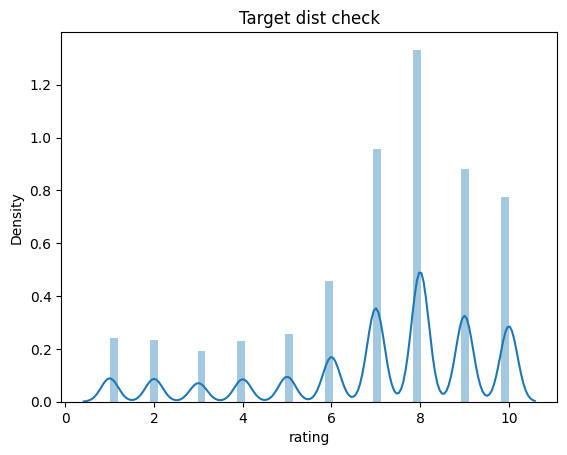

In [40]:
y = train_df['rating']

sns.distplot(y)
plt.title("Target dist check")
plt.show()

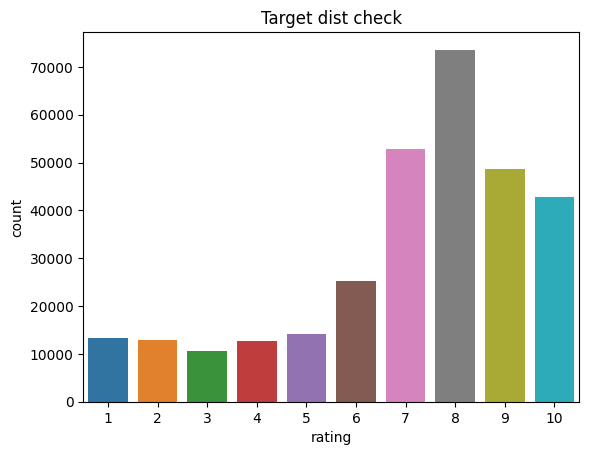

In [41]:
sns.countplot(x="rating", data=train_df)
plt.title("Target dist check")
plt.show()

# Catboost Feature Importance EDA

In [46]:
cols_nums = {}
for col in train_df.columns:
    print(f'{col} 범주 수: {train_df[col].nunique()}')
    cols_nums[col] = train_df[col].nunique()


user_id 범주 수: 59803
isbn 범주 수: 129777
rating 범주 수: 10
age 범주 수: 6
location_city 범주 수: 11374
location_state 범주 수: 1487
location_country 범주 수: 318
category 범주 수: 3873
publisher 범주 수: 10408
language 범주 수: 25
book_author 범주 수: 54716


In [48]:
train_df['category'].value_counts()

5       121221
3       108569
10       12019
21        7648
7         3132
         ...  
2334         1
2329         1
2328         1
2327         1
3872         1
Name: category, Length: 3873, dtype: int64

# 상관관계 분석

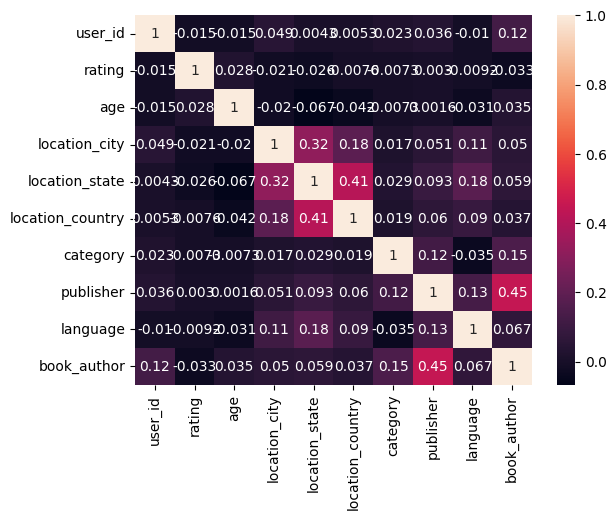

<Figure size 5000x100 with 0 Axes>

In [70]:
sns.heatmap(train_df.corr(), annot = True)
plt.figure(figsize = (50, 1))
plt.show()